In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import wfdb
import ast
from math import ceil
from ecgdetectors import Detectors

In [3]:
sampling_rate = 100
dataset_path = "data/physionet.org/files/ptb-xl/1.0.2"

In [22]:
# Load and convert annotation data
ecg_data = pd.read_csv(os.path.join(dataset_path, 'ptbxl_database.csv'), index_col='ecg_id')
ecg_data.scp_codes = ecg_data.scp_codes.apply(lambda x: ast.literal_eval(x))
print(ecg_data.head())

        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15     

In [23]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(os.path.join(dataset_path, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(data_dict):
    tmp = []
    for key in data_dict.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


def aggregate_description(data_dict):
    tmp = []
    for key in data_dict.keys():
        if key in data_dict.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].description)
    return list(set(tmp))

# Apply diagnostic superclass and description
ecg_data['diagnostic_superclass'] = ecg_data.scp_codes.apply(aggregate_diagnostic)
ecg_data['description'] = ecg_data.scp_codes.apply(aggregate_description)
print(ecg_data.head())

        patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15     

In [24]:
# ECG signal to be processed
ecg_id = 1
metadata = ecg_data.loc[[ecg_id]].to_dict(orient="records")[0]

In [19]:
def get_signal(filename):
    data = wfdb.rdsamp(filename)
    signal = np.array([data[0]])
    return signal

# Get ECG signal
if sampling_rate == 100:
    signal_filename = os.path.join(dataset_path, metadata["filename_lr"])
else:
    signal_filename = os.path.join(dataset_path, metadata["filename_hr"])
ecg_signal = get_signal(signal_filename)
num_samples = ecg_signal.shape[1]
seconds = int(num_samples / sampling_rate)
x_in_samples = np.arange(0, num_samples)
x_in_seconds = x_in_samples / sampling_rate
print(f"Signal dimensions:", ecg_signal.shape)

Signal dimensions: (1, 1000, 12)


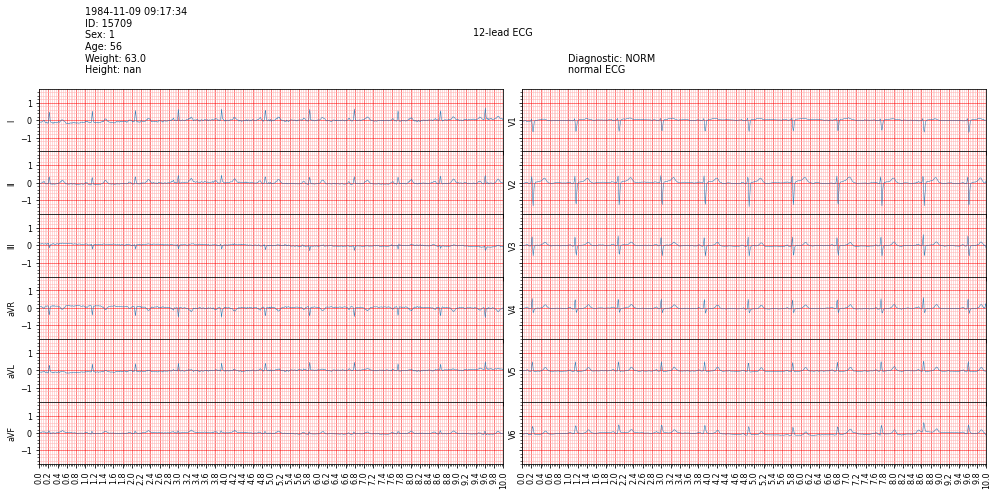

In [48]:
# Code extracted from https://github.com/dy1901/ecg_plot

# Lead name array in the same order of ECG
lead_index = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
# Lead display order
lead_order = [0, 6, 1, 7, 2, 8, 3, 9, 4, 10, 5, 11]


def _ax_plot(ax, x, y, secs=10, lwidth=0.5, amplitude_ecg=1.8, time_ticks=0.2):
    ax.set_xticks(np.arange(0, 11, time_ticks))
    ax.set_yticks(np.arange(-ceil(amplitude_ecg), ceil(amplitude_ecg), 1.0))

    ax.minorticks_on()
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))

    ax.set_ylim(-amplitude_ecg, amplitude_ecg)
    ax.set_xlim(0, secs)

    ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    ax.grid(which='minor', linestyle='-', linewidth='0.5', color=(1, 0.7, 0.7))

    ax.plot(x, y, linewidth=lwidth)


def plot_12_lead_ecg(ecg, columns=2):
    """Plot multi lead ECG chart.
        ecg        : m x n ECG signal data, which m is number of leads and n is length of signal.
        columns    : display columns, defaults to 2
    """
    leads = len(lead_order)

    plt.rcParams.update({'font.size': 8})
    fig, axs = plt.subplots(
        ceil(len(lead_order) / columns), columns,
        sharex=True,
        sharey=True,
        figsize=(0.7 * seconds * columns, 1.1 * leads / columns)
    )
    demographic = f'{metadata["recording_date"]} \n' \
                  f'ID: {int(metadata["patient_id"])} \n' \
                  f'Sex: {metadata["sex"]} \n' \
                  f'Age: {int(metadata["age"])} \n' \
                  f'Weight: {metadata["weight"]} \n' \
                  f'Height: {metadata["height"]}'
    diagnostic = f'Diagnostic: {metadata["diagnostic_superclass"][0]} \n' \
                 f'{metadata["description"][0]}'

    if metadata is not None:
        for ax, col in zip(axs[0], [demographic, diagnostic]):
            ax.annotate(col, xy=(0.1, 1.1), xytext=(0, 10),
                        xycoords='axes fraction', textcoords='offset points',
                        size='large', ha='left', va='baseline')

    fig.subplots_adjust(
        hspace=0,
        wspace=0.04,
        left=0.04,  # the left side of the subplots of the figure
        right=0.98,  # the right side of the subplots of the figure
        bottom=0.06,  # the bottom of the subplots of the figure
        top=0.85
    )

    step = 1.0 / sampling_rate
    for i in range(0, len(lead_order)):
        if (columns == 1):
            t_ax = axs[i]
        else:
            t_ax = axs[i // columns, i % columns]
        t_lead = lead_order[i]
        t_ax.set_ylabel(lead_index[t_lead])
        t_ax.tick_params(axis='x', rotation=90)
        _ax_plot(t_ax, np.arange(0, len(ecg[t_lead]) * step, step), ecg[t_lead], seconds)

    fig.suptitle('12-lead ECG')
    plt.show()
    
# Visualize 12-lead ECG signal
plot_12_lead_ecg(ecg_signal.transpose(), columns=2)

In [31]:
def decode_r_peaks_ann(r_peaks_str):
    r_peaks_list = r_peaks_str.split("[")[1:][0].split("]")[0].split(" ")
    r_peaks_ann = [int(s) for s in r_peaks_list if s.isdigit()]
    return r_peaks_ann

# Use I lead for detection
lead = np.squeeze(ecg_signal[:, :, lead_index.index('I')])

# Detect QRS complex
detectors = Detectors(100)
r_peaks = detectors.swt_detector(lead)
num_predicted_heart_beats = len(r_peaks)
print(f"Number of predicted heart beats: {num_predicted_heart_beats}")
print(f"Predicted locations: {r_peaks}")

# Get R peaks annotations
r_peaks_ann = decode_r_peaks_ann(metadata["r_peaks"])
num_actual_heart_beats = len(r_peaks_ann)
print(f"\nNumber of actual heart beats: {num_actual_heart_beats}")
print(f"Actual locations: {r_peaks_ann}")

Number of predicted heart beats: 10
Predicted locations: [118, 199, 297, 390, 484, 580, 676, 770, 861, 958]

Number of actual heart beats: 11
Actual locations: [22, 115, 208, 300, 393, 488, 583, 679, 773, 865, 961]


In [33]:
# Compute actual and predicted heart beat
r_timestamps = x_in_seconds[r_peaks]
rr_intervals_ms = (r_timestamps[1:] - r_timestamps[:-1]) * 1000
predicted_avg_bpm = round(num_predicted_heart_beats/seconds * 60, 2)
actual_avg_bpm = round(num_actual_heart_beats/seconds * 60, 2)
print(f"Predicted avg heart rate: {predicted_avg_bpm}")
print(f"Actual avg heart rate: {actual_avg_bpm}")

Predicted avg heart rate: 60.0
Actual avg heart rate: 66.0


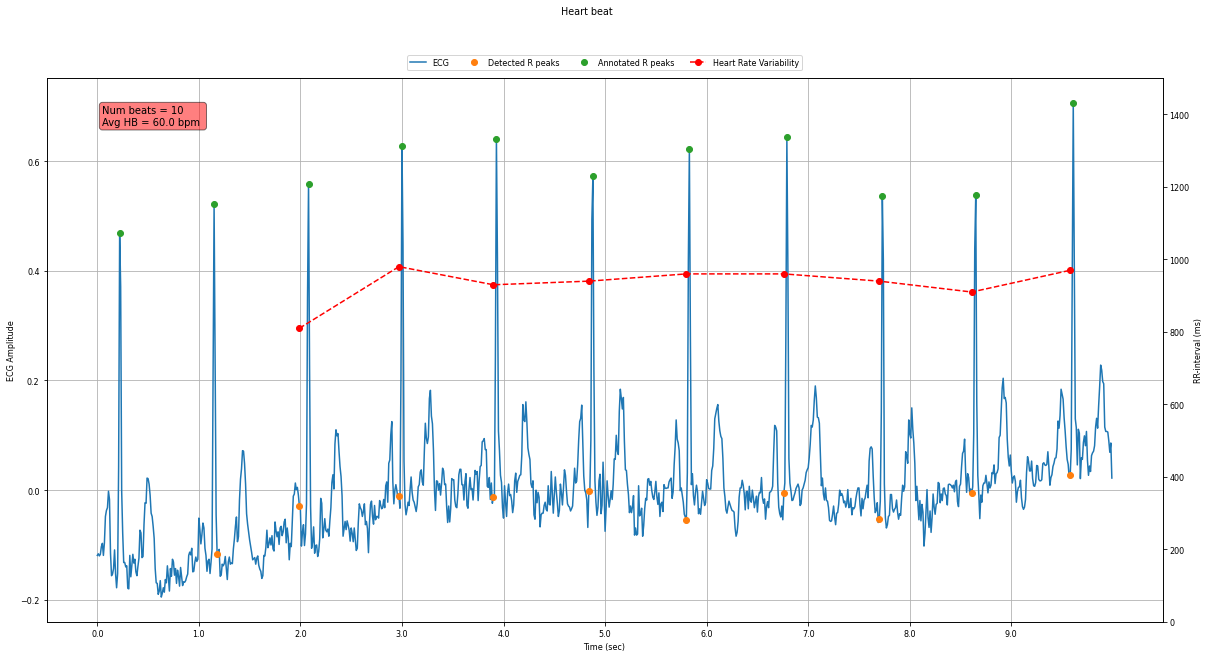

In [46]:
# Visualize heart beat
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
curve_1 = ax1.plot(lead, label="ECG")
curve_2 = ax1.plot(r_peaks, lead[r_peaks], "o", label="Detected R peaks")
curve_3 = ax1.plot(r_peaks_ann, lead[r_peaks_ann], "o", label="Annotated R peaks")
curve_4 = ax2.plot(r_peaks[1:], rr_intervals_ms, "ro--", label="Heart Rate Variability")
curves = curve_1 + curve_2 + curve_3 + curve_4
labels = [c.get_label() for c in curves]
ax1.legend(curves, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True)
ax2.text(0.05, 0.95, "Num beats = " + str(num_predicted_heart_beats) + "\nAvg HB = " + str(predicted_avg_bpm) + " bpm ",
         transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='red', alpha=0.5))

ax1.grid()
ax1.set_xticks(x_in_samples)
ax1.set_xticklabels(x_in_seconds)
ax1.locator_params(axis='x', nbins=seconds)
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel(r"ECG Amplitude")
ax2.set_ylim([0, 1500])
ax2.set_ylabel(r"RR-interval (ms)")
fig.suptitle("Heart beat")
plt.show()